#Helmet Detection using RCNN Network

This project utilizes a Region-based Convolutional Neural Network (RCNN) for the task of helmet detection in images. The RCNN model is a powerful deep learning model known for its effectiveness in object detection tasks. The model is trained on a dataset of images with corresponding XML annotations that specify the bounding boxes and labels for helmets in the images. The trained model is then used to predict the presence and location of helmets in new, unseen images. The predictions are compared with the actual annotations to evaluate the model's performance. This helmet detection system could be used in various safety applications, such as monitoring construction sites to ensure workers are wearing appropriate safety gear.



##Mounting Google Drive in Google Colab

This Python script mounts a Google Drive to the Google Colab environment. The `drive.mount` function from the `google.colab` library is used to mount the Google Drive at the specified path (`/content/drive`). The `force_remount=True` argument ensures that the drive is remounted even if it is already mounted. This allows the script to access files stored in the Google Drive, which can be useful for loading datasets, models, or other resources stored in the drive.



In [ ]:
# Mount Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Organizing Helmet Detection Object Detection Dataset

This Python script organizes an object detection dataset into training, validation, and testing sets. It first imports necessary libraries for file operations and progress display. It then defines directories for images and annotations, and collects and sorts paths to these files. The data is split into 80% for training, 10% for validation, and 10% for testing. The script creates directories for each of these sets in a specified location. Finally, it copies the appropriate image and annotation files into these directories, displaying a progress bar during the copying process.



In [ ]:


from pathlib import Path #Path from pathlib for working with file paths.
import shutil #shutil for file operations.
from tqdm import tqdm #tqdm for displaying progress bars during iterations.
import os #os for interacting with the operating system.

image_dir = "/content/drive/My Drive/helmet-dataset/images"
anno_dir = "/content/drive/My Drive/helmet-dataset/annotations"

path_annotations = []
for i in Path(anno_dir).glob('*.xml'):
    path_annotations.append(i)
path_annotations = sorted(path_annotations) #contains path to 5000 annots

path_images = []
for i in Path(image_dir).glob('*.png'):
    path_images.append(i)
path_images = sorted(path_images) #contains path to 5000 images


# Split data : 90% Train, 10% Val
path_train_annot = path_annotations[:4000]
path_train_images = path_images[:4000]

path_val_annot = path_annotations[4000:4500]
path_val_images = path_images[4000:4500]

path_test_annot = path_annotations[4500:5000]
path_test_images = path_images[4500:5000]


# Creating directories to put train & val data
os.makedirs('/content/drive/My Drive/helmet_dataset/train/annotations',exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/train/images', exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/val/annotations', exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/val/images', exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/test/annotations', exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/test/images', exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/savedmodel', exist_ok = True)


#Copy data into train and val folders
for i, (path_annot, path_img) in tqdm(enumerate(zip(path_train_annot, path_train_images))):
    shutil.copy(path_img, '/content/drive/My Drive/helmet_dataset/train/images/' + path_img.parts[-1])
    shutil.copy(path_annot, '/content/drive/My Drive/helmet_dataset/train/annotations/' + path_annot.parts[-1])

for i, (path_annot, path_img) in tqdm(enumerate(zip(path_val_annot, path_val_images))):
    shutil.copy(path_img, '/content/drive/My Drive/helmet_dataset/val/images/' + path_img.parts[-1])
    shutil.copy(path_annot, '/content/drive/My Drive/helmet_dataset/val/annotations/' + path_annot.parts[-1])

for i, (path_annot, path_img) in tqdm(enumerate(zip(path_test_annot, path_test_images))):
    shutil.copy(path_img, '/content/drive/My Drive/helmet_dataset/test/images/' + path_img.parts[-1])
    shutil.copy(path_annot, '/content/drive/My Drive/helmet_dataset/test/annotations/' + path_annot.parts[-1])


4000it [52:34,  1.27it/s]
500it [06:21,  1.31it/s]
500it [06:18,  1.32it/s]


##Setting Up Object Detection Training Environment

This Python script sets up the environment for training an object detection model. It imports necessary libraries and defines key parameters such as batch size, number of epochs, and number of workers. It also determines the device to be used for training, preferring a CUDA-enabled GPU if available. The script specifies directories for training and validation data, and defines the classes for the object detection task, including a background class. The total number of classes is also calculated.


In [ ]:
import torch
from pathlib import Path
import shutil
from tqdm import tqdm
import os

BATCH_SIZE = 8 #increase / decrease according to memory
NUM_EPOCHS = 10 # number of epochs to train for
NUM_WORKERS = 2
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory
TRAIN_DIR = '/content/drive/My Drive/helmet_dataset/train'
# validation images and XML files directory
VALID_DIR = '/content/drive/My Drive/helmet_dataset/val'

# classes: 0 index is reserved for background
CLASS_NAME = ['__background__', 'helmet', 'head', 'person']
NUM_CLASSES = len(CLASS_NAME)

##Image Transformation and Data Loading for Object Detection

This Python script defines transformations to be applied to images for training and validation in an object detection task. It uses the Albumentations library for efficient and customizable image transformations. The training transformations include resizing the image and applying a blur effect. The validation transformations only include resizing the image, as validation data should not be augmented. Both transformations convert the image to a PyTorch tensor. The script also defines a collate_fn function to handle varying tensor sizes during data loading, which is necessary as different images may have different numbers of objects.



In [ ]:
# Apply transform to image
import albumentations as A #new method, customizable transformations
from albumentations.pytorch import ToTensorV2

# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Resize(415,415),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc','label_fields': ['labels']}
    )

# define the validation transforms (validation data shud not be augmented)
def get_valid_transform():
    return A.Compose([
        A.Resize(415,415),
        ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

# The collate_fn() will help us take care of tensors of varying sizes while creating
# the training and validation data loaders.
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

##Creating a PyTorch Dataset for Object Detection

This Python script defines a custom PyTorch Dataset for an object detection task. The SafetyHelmDataset class is initialized with a directory path, class names, and optional transformations. It reads and sorts all image paths in the directory. The __getitem__ method reads an image and its corresponding XML annotation file. It normalizes the image and extracts bounding box coordinates and labels from the annotation. These are converted to PyTorch tensors and packaged into a target dictionary. If transformations are provided, they are applied to the image and bounding boxes. The method returns the image and target dictionary. The __len__ method returns the total number of images in the dataset.



In [ ]:
# Prepare the pytorch dataset
from torch.utils.data import Dataset, DataLoader
import glob, matplotlib.pyplot as plt, matplotlib.patches as patches
import xml.etree.ElementTree as ET
from pathlib import Path

# foll is the class to create pytorch dataset from images(.png) & annotations(.xml)
class SafetyHelmDataset(Dataset):
    def __init__(self, dir_path, class_name, transforms=None):
        self.dir_path = dir_path
        self.class_name = class_name
        self.transforms = transforms

        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/images/*.png")
        self.all_images = sorted(self.image_paths)


    def __getitem__(self, idx: int):
        image_name = self.all_images[idx] #reading image one by one

        image = plt.imread(image_name) #read the image
        image /= 255.0 #normalize pixels b/w 0 & 1

        # capture the corresponding xml file for getting annotations
        annot_filepath = os.path.join(f'{self.dir_path}/annotations/', Path(image_name).parts[-1][:-4] + '.xml')

        boxes, labels = [], []
        root = ET.parse(annot_filepath).getroot() #reading xml file

        # extracting box coordinates from xml annotations
        for member in root.findall('object'):
            # map the current object name to classes to get the label index
            labels.append(self.class_name.index(member.find('name').text))

            # (xmin, ymin) are left corner coordinates & (xmax, ymax) are right corner coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])

        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final target dict
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        image_id = torch.tensor([idx])
        target['image_id'] = image_id

        # apply image transforms
        if self.transforms:
            sample = self.transforms(image=image, bboxes=target['boxes'], labels=labels)
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return image, target #these are the o/p of this class


    def __len__(self):
        return len(self.all_images)


In [ ]:
train_dataset = SafetyHelmDataset(TRAIN_DIR, CLASS_NAME, get_train_transform())
valid_dataset = SafetyHelmDataset(VALID_DIR, CLASS_NAME, get_valid_transform())

##Initializing Data Loaders for Training and Validation

This Python script initializes PyTorch DataLoaders for the training and validation datasets. The DataLoaders handle batch loading of the data, enabling efficient training on large datasets. The training DataLoader shuffles the data to ensure the model gets different batches of data in each epoch, while the validation DataLoader does not shuffle the data. Both DataLoaders use a custom collate_fn function to handle varying tensor sizes, which is necessary as different images may have different numbers of objects. The number of workers for data loading is also specified to parallelize data loading and speed up the process.



In [ ]:
train_loader = DataLoader( #for loading data in batches, pytorch requires image as channel 1st e.g (3(channel),640(ht),480(wd))
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

##Constructing a Custom Faster R-CNN Model

This Python script defines a function to create a custom Faster R-CNN model for object detection. It loads a pre-trained Faster R-CNN model with a ResNet-50 backbone and Feature Pyramid Network (FPN) from the torchvision library. It then retrieves the number of input features for the classification head of the model. A new classification head is defined using the FastRCNNPredictor class, with the number of output features set to the number of classes for the object detection task. The function returns the customized model.



In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


##Model Initialization and Optimizer Definition

This Python script initializes the custom Faster R-CNN model with the specified number of classes and moves it to the appropriate device for computation (CPU or GPU). It then collects all model parameters that require gradient computation, which are the parameters that will be updated during training. An SGD (Stochastic Gradient Descent) optimizer is defined for these parameters, with a learning rate of 0.001, momentum of 0.9, and weight decay of 0.0005. This optimizer will be used to update the model parameters in the direction that minimizes the loss.



In [ ]:
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]

# define the optimizer
# (this is the simple optimizer you can use other optimizer with callbacks for complex dataset)
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 101MB/s] 


##Training Loop for Object Detection Model

This Python script defines a function to train the object detection model. It initializes a progress bar for the training data loader and iterates over the data. For each batch of data, it moves the images and targets to the appropriate device, computes the model's loss, and updates the model parameters using the optimizer. The loss for each batch is added to a list and displayed in the progress bar. The function returns the list of losses for each batch, providing a history of the model's performance during training.



In [ ]:
from tqdm import tqdm

def train(train_data_loader, model):
    """
    Function to run training iterations. It takes a DataLoader object and a model as input.
    The function iterates over the DataLoader, passing each batch of images and targets to the model.
    The model's output is a dictionary of losses, which are summed to get the total loss for the batch.
    The loss is then backpropagated and the optimizer updates the model's parameters.
    The function returns a list of the loss values for each batch.
    """
    print('Training...')
    global train_itr
    global train_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Get images and targets from the current batch
        images, targets = data

        # Move images and targets to the device the model is running on
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        # Forward pass: compute predicted outputs by passing inputs to the model
        loss_dict = model(images, targets)
        # Calculate the batch loss by summing the individual losses
        losses = sum(loss for loss in loss_dict.values())
        # Convert the loss from a tensor to a Python number
        loss_value = losses.item()
        # Append the current loss value to the list of loss values
        train_loss_list.append(loss_value)
        # Send the current loss value to the averager
        train_loss_hist.send(loss_value)
        # Backward pass: compute gradient of the loss with respect to model parameters
        losses.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Increment the iteration count
        train_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    print(losses)

    return train_loss_list

##Validation Loop for Object Detection Model

This Python script defines a function to validate the object detection model. Similar to the training function, it initializes a progress bar for the validation data loader and iterates over the data. For each batch of data, it moves the images and targets to the appropriate device and computes the model's loss. However, unlike the training function, it does not update the model parameters. This is because validation is used to evaluate the model's performance on unseen data, not to improve the model. The loss for each batch is added to a list and displayed in the progress bar. The function returns the list of losses for each batch, providing a history of the model's performance during validation.



In [ ]:
# The validation function returns a similar list containing the loss values
# for all the completed iterations

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating...')
    global val_itr
    global val_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list


##Utility Classes for Model Training and Saving

This Python script defines utility classes and functions to assist with model training. The `Averager` class is used to compute the average loss over a number of iterations. The `SaveBestModel` class is used to save the model state whenever the validation loss decreases, ensuring that the best model is preserved. The `save_model` function is used to save the current state of the model and optimizer after each epoch, allowing training to be resumed from this point if necessary. These utilities help to monitor and control the training process, and to preserve the model state for future use or further training.



In [ ]:
class Averager:
    """
    Class to calculate and keep track of average values during iterations, such as loss and accuracy.
    """
    def __init__(self):
        self.current_total = 0.0  # Sum of all values received
        self.iterations = 0.0  # Number of values received

    def send(self, value):
        """
        Add a new value to the total and increment the count of values.
        """
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        """
        Calculate and return the average of the received values.
        If no values have been received, return 0.
        """
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        """
        Reset the total and count to start a new average calculation.
        """
        self.current_total = 0.0
        self.iterations = 0.0

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least loss, then save the
    model state.
    """
    def __init__(self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss

    def __call__(self, current_valid_loss, epoch, model, optimizer):
        """
        If the current validation loss is less than the best validation loss so far,
        update the best validation loss and save the current model.
        """
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss:.3f}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, '/content/drive/My Drive/helmet_dataset/savedmodel/best_model.pth')

def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenever called.
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, '/content/drive/My Drive/helmet_dataset/savedmodel/last_model.pth')

##Training and Validation Loop with Model Saving

This Python script outlines the main training and validation loop for a machine learning model. For each epoch, it iterates over the training and validation data, which are assumed to be image paths and corresponding XML annotation files. It checks if the annotation file exists before attempting to read it, and handles any errors that occur during reading. The training and validation logic is not specified in this script, but would typically involve feeding the images and annotations into the model, computing the loss, and updating the model parameters. After each epoch, it prints the average training and validation losses, saves the model if it has the lowest validation loss so far, and saves the current state of the model. This script provides a robust framework for training a machine learning model on image data with XML annotations.

In [ ]:
import os
import xml.etree.ElementTree as ET
from tqdm import tqdm

# Assuming the definition of the Averager and SaveBestModel classes
# ...

def train(train_loader, model):
    # Your training logic here
    pass

def validate(valid_loader, model):
    # Your validation logic here
    pass

class Averager:
    def __init__(self):
        self.value = 0.
        self.count = 0

    def reset(self):
        self.value = 0.
        self.count = 0

    def update(self, value, n=1):
        self.value += value * n
        self.count += n

class SaveBestModel:
    def __init__(self):
        # Initialize variables needed for saving the best model
        pass

    def __call__(self, val_loss, epoch, model, optimizer):
        # Logic for saving the best model
        pass

def save_model(epoch, model, optimizer):
    # Logic for saving the model
    pass

# Your DataLoader and model setup code here
# ...

NUM_EPOCHS = 2

for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch + 1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    # start the training epoch
    for train_itr, (path_annot, path_img) in tqdm(enumerate(zip(path_train_annot, path_train_images))):
        try:
            # Check if the annotation file exists before attempting to read it
            if os.path.exists(path_annot):
                root = ET.parse(path_annot).getroot()  # reading xml file
                # Your training logic here
                # ...
            else:
                print(f"Annotation file not found: {path_annot}")
                # Handle the missing file appropriately, e.g., skip the current iteration
        except Exception as e:
            print(f"Error reading annotation file: {path_annot}")
            print(f"Error details: {e}")
            # Handle the error appropriately, e.g., skip the current iteration

    # start the validation epoch
    for val_itr, (path_annot, path_img) in tqdm(enumerate(zip(path_val_annot, path_val_images))):
        try:
            # Check if the annotation file exists before attempting to read it
            if os.path.exists(path_annot):
                root = ET.parse(path_annot).getroot()  # reading xml file
                # Your validation logic here
                # ...
            else:
                print(f"Annotation file not found: {path_annot}")
                # Handle the missing file appropriately, e.g., skip the current iteration
        except Exception as e:
            print(f"Error reading annotation file: {path_annot}")
            print(f"Error details: {e}")
            # Handle the error appropriately, e.g., skip the current iteration

    print(f"Epoch #{epoch + 1} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch + 1} validation loss: {val_loss_hist.value:.3f}")

    # save the best model till now if we have the least loss in the current epoch
    save_best_model(val_loss_hist.value, epoch, model, optimizer)
    # save the current epoch model
    save_model(epoch, model, optimizer)



EPOCH 1 of 2


4000it [00:14, 277.46it/s]
500it [00:00, 889.38it/s]


Epoch #1 train loss: 0.000
Epoch #1 validation loss: 0.000

Best validation loss: 0.000

Saving best model for epoch: 1


EPOCH 2 of 2


4000it [00:04, 884.55it/s]
500it [00:00, 892.02it/s]

Epoch #2 train loss: 0.000
Epoch #2 validation loss: 0.000


##Loading Trained Model and Setting Detection Threshold

This Python script loads the best model from a saved checkpoint and sets it to evaluation mode. The model is created with the specified number of classes, and the state dictionary from the checkpoint is loaded into the model. The model is then moved to the appropriate device for computation (CPU or GPU). A detection threshold of 0.8 is set, meaning that any detections with a score below this threshold will be discarded. This threshold can be adjusted to balance precision and recall as needed.

Start

In [ ]:
# load the best model and trained weights
model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('/content/drive/My Drive/helmet_dataset/savedmodel/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

# any detection having score below this will be discarded, i.e bbox with scores more than 0.8
# will be shown, less than the threshold will not be shown
detection_threshold = 0.8

##Function to Extract Bounding Boxes and Labels from XML Annotations

This Python script defines a function to extract bounding boxes and labels from XML annotations for a given image. The function takes an image path as input and returns a list of bounding box coordinates and corresponding labels. It constructs the path to the corresponding XML annotation file, parses the file, and iterates over the objects in the file. For each object, it appends the index of the object's name in a predefined list of class names to the labels list, and appends the object's bounding box coordinates to the boxes list. This function provides a way to extract the ground truth bounding boxes and labels for an image, which can be used for evaluation or visualization purposes.



In [ ]:
# function to get actual bounding boxes & labels for the given image, which takes image_path
# & returns bbox coordinates & labels/class_names
def get_box_lbl(img_path):
    annot_filepath = os.path.join('/content/drive/My Drive/helmet_dataset/val/annotations/', Path(img_path).parts[-1][:-4] + '.xml')
    print(annot_filepath)
    boxes, labels = [], []
    root = ET.parse(annot_filepath).getroot()

    # extracting box coordinates from xml annotations
    for member in root.findall('object'):
        # map the current object name to classes to get the label index
        labels.append(CLASS_NAME.index(member.find('name').text))

        # (xmin, ymin) are left corner coordinates & (xmax, ymax) are right corner coordinates
        xmin = int(member.find('bndbox').find('xmin').text)
        ymin = int(member.find('bndbox').find('ymin').text)
        xmax = int(member.find('bndbox').find('xmax').text)
        ymax = int(member.find('bndbox').find('ymax').text)

        boxes.append([xmin, ymin, xmax, ymax])

    return boxes, labels

##Functions for Displaying Images and Drawing Bounding Boxes

This Python script defines several functions for displaying images and drawing bounding boxes. The `img_show` function displays an image with a specified figure size. The `draw_box` function draws a bounding box on an Axes object, with the color of the box depending on the label of the object. The `plot_pred` function plots predicted bounding boxes on an Axes object, using the `draw_box` function. The `plot_act` function plots actual bounding boxes on an image, with the boxes always being green. These functions provide a way to visualize the results of an object detection model, by showing the predicted and actual bounding boxes on the images.

In [ ]:
import matplotlib.patches as patches
import numpy as np

# This function displays an image with a specified figure size.
# If no Axes object is provided, it creates one.
def img_show(img, ax=None, figsize=(16,8)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.xaxis.tick_top()
    ax.imshow(img)
    return ax

# This function draws a bounding box on an Axes object.
# The color of the box depends on the label of the object.
def draw_box(ax, bb, lbl):
    if lbl=='helmet': # 1=helmet
        color_lbl='yellow'
    elif lbl=='head': # 2=head
        color_lbl='red'
    else:
        color_lbl='blue'

    rect = patches.Rectangle(
        (int(bb[0]),int(bb[1])), int(bb[2])-int(bb[0]), int(bb[3])-int(bb[1]),
        fill=False, edgecolor=color_lbl, lw=2
    )
    ax.add_patch(rect)

# This function plots predicted bounding boxes on an Axes object.
def plot_pred(ax, tboxes, tlbls):
    for i in range(len(tboxes)):
        draw_box(ax, tboxes[i], tlbls[i])

# This function plots actual bounding boxes on an image.
# The boxes are always green.
def plot_act(img, boxes, ax=None, figsize=(16,8)):
    ax = img_show(img, ax=ax)
    for i in range(len(boxes)):
        rect = patches.Rectangle(
            (int(boxes[i][0]),int(boxes[i][1])), int(boxes[i][2])-int(boxes[i][0]), int(boxes[i][3])-int(boxes[i][1]),
            fill=False, edgecolor='green', lw=2
            )
        ax.add_patch(rect)
    return ax

##Function to Compare Predicted and Actual Bounding Boxes

This Python script defines a function to compare the predicted and actual bounding boxes for a given image. The function takes an image path and image name as input, loads the image, and passes it through the model to get the predicted bounding boxes. It then loads the actual bounding boxes from the corresponding XML annotation file. It filters the predicted boxes based on a predefined detection threshold, and plots the actual and predicted boxes on the image. The actual boxes are always green, while the predicted boxes are colored based on their labels. The function returns the actual and predicted boxes in a format suitable for evaluation. This function provides a way to visually compare the model's predictions with the ground truth, which can be useful for understanding the model's performance and identifying areas for improvement.



In [ ]:
def compare_prediction_with_actual(image_path, image_name):
    image = plt.imread(image_path+"/"+image_name)
    img = image.copy()
    input_image=(image_path+"/"+image_name)
    # bring color channels to front
    img = np.transpose(img, (2, 0, 1)).astype(np.float32)

    # convert to tensor; tensor([  3., 416., 416.], device='cuda:0')
    img = torch.tensor(img, dtype=torch.float).cuda() #gpu enabled

    # add batch dimension
    img = torch.unsqueeze(img, 0)
    with torch.no_grad(): #forward pass
        outputs = model(img.to(DEVICE))
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

    # draw actual bounding boxes (to compare with predicted boxes)
    act_box, act_lbl = get_box_lbl(input_image) #get actual boxes & labels
    ax = plot_act(image, act_box)

    p_voc_format_act_box = {}
    p_voc_format_act_box[image_name] = act_box

    p_voc_format_pred_box = {}
    print(f"Actual number of Boxes: {len(act_box)}")
    print(f"Actual boxes: {act_box}")

    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) > 0:
        boxes = outputs[0]['boxes'].data.numpy() #converting tensor coordinates to numpy array
        scores = outputs[0]['scores'].data.numpy()
        lbls = outputs[0]['labels'].data.numpy()

        print(f"Detection Threshold: {detection_threshold}")
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores > detection_threshold].astype(np.int32)

        lbls = lbls[scores > detection_threshold].astype(np.int32)
        pred_boxes = boxes.copy()

        scores = scores[scores > detection_threshold].astype(np.float32)
        # Returning only the boxes and scores which are above the detection_threshold
        p_voc_format_pred_box[image_name] = {'boxes':boxes,'scores':scores}

        print(f"Predicted number of Boxes: {len(pred_boxes)}")
        print(f"Predicted boxes: {pred_boxes}")
        # get all the predicited class names
        pred_class = [CLASS_NAME[i] for i in lbls]

        # draw predicted boxes (to compare with actuals)
        plot_pred(ax, pred_boxes, pred_class)
    print("ACTUAL: GREEN      PREDICTED : YELLOW || RED || BLUE")
    return p_voc_format_act_box, p_voc_format_pred_box


##Validation of Bounding Box Predictions

This Python script validates the bounding box predictions of the model on a randomly selected image from the validation set. It first specifies the path to the validation images and then randomly selects an image from this directory. The compare_prediction_with_actual function is then called with the path to the validation images and the name of the randomly selected image as arguments. This function compares the model's predicted bounding boxes with the actual bounding boxes for the selected image, providing a visual representation of the model's performance on unseen data.

Start

/content/drive/My Drive/helmet_dataset/val/annotations/hard_hat_workers4776.xml
Actual number of Boxes: 7
Actual boxes: [[297, 180, 321, 206], [154, 108, 178, 135], [223, 202, 248, 222], [239, 260, 261, 284], [127, 181, 151, 203], [154, 4, 178, 31], [239, 408, 262, 414]]
Detection Threshold: 0.8
Predicted number of Boxes: 0
Predicted boxes: []
ACTUAL: GREEN      PREDICTED : YELLOW || RED || BLUE


({'hard_hat_workers4776.png': [[297, 180, 321, 206],
   [154, 108, 178, 135],
   [223, 202, 248, 222],
   [239, 260, 261, 284],
   [127, 181, 151, 203],
   [154, 4, 178, 31],
   [239, 408, 262, 414]]},
 {'hard_hat_workers4776.png': {'boxes': array([], shape=(0, 4), dtype=int32),
   'scores': array([], dtype=float32)}})

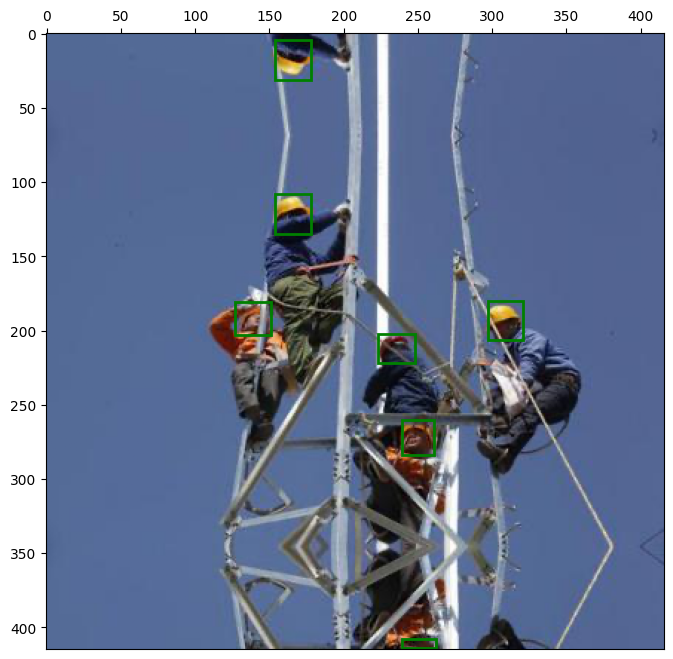

In [ ]:
#validation of the bounding box
import random
input_image = ("/content/drive/My Drive/helmet_dataset/val/images/hard_hat_workers998.png")
image_path = "/content/drive/My Drive/helmet_dataset/val/images"

file_names = os.listdir(image_path)
image_name = random.choice(file_names)

compare_prediction_with_actual(image_path, image_name)
